# Tasks

**Step 1:** Write a code to parse the data on weather in Chicago in November 2017 from the website:
https://code.s3.yandex.net/data-analyst-eng/chicago_weather_2017.html

**Step 2:** Exploratory data analysis
1. Find the number of taxi rides for each taxi company for November 15-16, 2017. Name the resulting field trips_amount and print it along with the company_name field. Sort the results by the trips_amount field in descending order.
2. Find the number of rides for every taxi company whose name contains the words "Yellow" or "Blue" for November 1-7, 2017. Name the resulting variable trips_amount. Group the results by the company_name field.
3. In November 2017, the most popular taxi companies were Flash Cab and Taxi Affiliation Services. Find the number of rides for these two companies and name the resulting variable trips_amount. Join the rides for all other companies in the group "Other." Group the data by taxi company names. Name the field with taxi company names company. Sort the result in descending order by trips_amount.
4. Find out where rides most often end. Find the average number of drop-offs that occurred daily in each Chicago neighborhood in November 2017. Name the resulting field average_trips. To retrieve the names of the neighborhoods, use the name field from the neighborhoods table. Rename it as dropoff_location_name in the resulting table. Sort the result in descending order by average_trips.

**Step 3:** Test the hypothesis that the duration of rides from the the Loop to O'Hare International Airport changes on rainy Sundays.
1. Retrieve the identifiers of the O'Hare and Loop neighborhoods from the neighborhoods table.
2. For each hour, retrieve the weather condition records from the weather_records table. Using the CASE operator, break all hours into two groups: "Bad" if the description field contains the words '"rain" or "storm," and "Good" for others. Name the resulting field weather_conditions. The final table must include two fields: date and hour (ts) and weather_conditions.
3. Retrieve from the trips table all the rides that started in the Loop (neighborhood_id: 50) and ended at O'Hare (neighborhood_id: 63) on a Sunday. Get the weather conditions for each ride. Use the method you applied in the previous task. Also retrieve the duration of each ride. Ignore rides for which data on weather conditions is not available.

**Step 4:** Exploratory data analysis (Python)
You have files that contain the data retrieved with queries from the previous tasks.
project_sql_result_01.csv — the result of the first query. It contains the following data:
company_name: taxi company name
trips_amount: the number of rides for each taxi company on November 15-16, 2017.
project_sql_result_04.csv — the result of the second query. It contains the following data:
dropoff_location_name: Chicago neighborhoods where rides ended
average_trips: the average number of rides that ended in each neighborhood in November 2017.

**Step 5:** Testing hypotheses (Python)
project_sql_result_07.csv — the result of the last query. It contains data on rides from the Loop to O'Hare International Airport. Remember, these are the table's field values:
start_ts
pickup date and time
weather_conditions
weather conditions at the moment the ride started
duration_seconds
ride duration in seconds
Test the hypothesis:
"The average duration of rides from Loop neighborhood to O'Hare International Airport changes on rainy Sundays."

# Solutions

### Step 1

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
URL='https://code.s3.yandex.net/data-analyst-eng/chicago_weather_2017.html'
req = requests.get(URL)
soup = BeautifulSoup(req.text, 'lxml')
table = soup.find('table', attrs={"id": "weather_records"})
heading_table=[]
for row in table.find_all('th'):
    heading_table.append(row.text)
content=[]
for row in table.find_all('tr'):
    if not row.find_all('th'):
        content.append([element.text for element in row.find_all('td')])
weather_records = pd.DataFrame(content, columns = heading_table)
print(weather_records)

           Date and time Temperature       Description
0    2017-11-01 00:00:00     276.150     broken clouds
1    2017-11-01 01:00:00     275.700  scattered clouds
2    2017-11-01 02:00:00     275.610   overcast clouds
3    2017-11-01 03:00:00     275.350     broken clouds
4    2017-11-01 04:00:00     275.240     broken clouds
..                   ...         ...               ...
692  2017-11-29 20:00:00     281.340        few clouds
693  2017-11-29 21:00:00     281.690      sky is clear
694  2017-11-29 22:00:00     281.070        few clouds
695  2017-11-29 23:00:00     280.060      sky is clear
696  2017-11-30 00:00:00     278.460      sky is clear

[697 rows x 3 columns]


### Step 2 + 3

**Q**
<br>
Print the company_name field. Find the number of taxi rides for each taxi company for November 15-16, 2017, name the resulting field trips_amount, and print it, too. Sort the results by the trips_amount field in descending order.

``` sql
select company_name, count(*) as trips_amount
from cabs inner join trips on cabs.cab_id = trips.cab_id
where trips.start_ts::date in ('2017-11-15','2017-11-16')
group by cabs.company_name
order by trips_amount desc;
```

**Q**
<br>
Find the number of rides for every taxi company whose name contains the words "Yellow" or "Blue" for November 1-7, 2017. Name the resulting variable trips_amount. Group the results by the company_name field.

```sql
SELECT
    subquery.company_name,
    COUNT(subquery.cab_id) AS trips_amount
FROM
    trips
LEFT JOIN
	(
	SELECT --select cab_id and company_name for 2019-11-15 and 2019-11-16
        cab_id,
        company_name
	FROM
		cabs
	) AS subquery ON subquery.cab_id = trips.cab_id
WHERE 
    CAST(trips.start_ts AS date) in 
    ('2017-11-01',
     '2017-11-02',
     '2017-11-03',
     '2017-11-04',
     '2017-11-05',
     '2017-11-06',
     '2017-11-07') AND 
     (subquery.company_name LIKE '%Yellow%' OR subquery.company_name LIKE '%Blue%')
GROUP BY
    subquery.company_name
ORDER BY
    trips_amount DESC;
```

**Q**
<br>
For November 1-7, 2017, the most popular taxi companies were Flash Cab and Taxi Affiliation Services. Find the number of rides for these two companies and name the resulting variable trips_amount. Join the rides for all other companies in the group "Other." Group the data by taxi company names. Name the field with taxi company names company. Sort the result in descending order by trips_amount.

```sql
SELECT
    CASE 
        WHEN cabs.company_name NOT IN ('Flash Cab', 'Taxi Affiliation Services') THEN 'Other'
        ELSE cabs.company_name 
    END AS company,
    COUNT(trips.trip_id) AS trips_amount   
FROM
    trips
LEFT JOIN cabs ON cabs.cab_id = trips.cab_id
WHERE
    CAST(trips.start_ts AS date) >= '2017-11-01' AND
    CAST(trips.start_ts AS date) < '2017-11-08'
GROUP BY
    company
ORDER BY
    trips_amount DESC;
```

**Q**
<br>
Find out where rides most often end. Find the average daily number of drop-offs in each Chicago neighborhood in the month that we have data for (November 2017). Name the resulting field average_trips. To retrieve the names of the neighborhoods, use the name field from the neighborhoods table. Rename it as dropoff_location_name in the resulting table. Sort the result in descending order by average_trips.

```sql
select name as dropoff_location_name, avg(cnt_amount) as average_trips
from (select name, extract('day' from end_ts) as day, count(*) cnt_amount
      from trips
               left join neighborhoods on trips.dropoff_location_id = neighborhoods.neighborhood_id
      group by name, extract('day' from end_ts)) as subq
group by name
order by average_trips desc
```

**Q**
<br>

Retrieve the identifiers of the O'Hare and Loop neighborhoods from the neighborhoods table.

```sql

select distinct neighborhood_id, name
 from trips left join neighborhoods on trips.dropoff_location_id = neighborhoods.neighborhood_id

         where name LIKE '%%Hare' OR name LIKE 'Loop'

```

**Q**
<br>
For each hour, retrieve the weather condition records from the weather_records table. Using the CASE operator, break all hours into two groups: "Bad" if the description field contains the words '"rain" or "storm," and "Good" for others. Name the resulting field weather_conditions. The final table must include two fields: date and hour (ts) and weather_conditions.

```sql
SELECT
    DATE_TRUNC('hour', ts) AS ts,
    CASE 
        WHEN description LIKE '%rain%' OR description LIKE '%storm%' THEN 'Bad'
        ELSE 'Good'
    END AS weather_conditions
FROM
    weather_records


```

**Q**
<br>

Retrieve from the trips table all the rides that started in the Loop (neighborhood_id: 50) and ended at O'Hare (neighborhood_id: 63) on a Saturday. Get the weather conditions for each ride. Use the method you applied in the previous task. Also retrieve the duration of each ride. Ignore rides for which data on weather conditions is not available.
The table columns should be in the following order:
start_ts
weather_conditions
duration_seconds
Sort by start_ts.

```sql
SELECT trips.start_ts,
       CASE
           WHEN description LIKE '%rain%' OR description LIKE '%storm%' THEN 'Bad'
           ELSE 'Good'
           END                                         AS weather_conditions,
       extract('hour' from (end_ts - start_ts)) * 3600 as duration_seconds
from trips
         inner join weather_records on trips.start_ts = weather_records.ts
where pickup_location_id = 50
  and dropoff_location_id = 63
  and extract('isodow' from start_ts) = 6
ORDER BY trips.start_ts
```

### Step 4+5

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats as st

In [3]:
q1_results = pd.read_csv('https://code.s3.yandex.net/learning-materials/data-analyst-eng/project_sql_result_01.csv')
q4_results = pd.read_csv('https://code.s3.yandex.net/learning-materials/data-analyst-eng/project_sql_result_04.csv')
q7_results = pd.read_csv('https://code.s3.yandex.net/learning-materials/data-analyst-eng/project_sql_result_07.csv')

In [4]:
def get_precent_of_na_df(df,num):
    df_nulls = pd.DataFrame(df.isna().sum(),columns=['Missing Values'])
    df_nulls['Percent of Nulls'] = round(df_nulls['Missing Values'] / df.shape[0],num) *100
    return df_nulls
        

def get_info(df,num):
    print('Head:')
    print()
    display(df.head())
    print ('-'*120)
    print('Info:')
    print()
    display(df.info())
    print ('-'*120)
    print('Describe:')
    print()
    display(df.describe())
    print ('-'*120)
    display(df.describe(include='object'))
    print()
    print('Columns with nulls:')
    display(get_precent_of_na_df(df,num))
    print ('-'*120)
    print('Shape:')
    print(df.shape)
    print ('-'*120)
    print('Duplicated:')
    print('We have {} duplicated rows!'.format(df.duplicated().sum()))

In [5]:
get_info(q1_results,4)

Head:



,company_name,trips_amount
0,Flash Cab,19558
1,Taxi Affiliation Services,11422
2,Medallion Leasin,10367
3,Yellow Cab,9888
4,Taxi Affiliation Service Yellow,9299


------------------------------------------------------------------------------------------------------------------------
Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   company_name  64 non-null     object
 1   trips_amount  64 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


None

------------------------------------------------------------------------------------------------------------------------
Describe:



,trips_amount
count,64.000000
mean,2145.484375
std,3812.310186
min,2.000000
25%,20.750000
50%,178.500000
75%,2106.500000
max,19558.000000


------------------------------------------------------------------------------------------------------------------------


,company_name
count,64
unique,64
top,4615 - 83503 Tyrone Henderson
freq,1



Columns with nulls:


,Missing Values,Percent of Nulls
company_name,0,0.0
trips_amount,0,0.0


------------------------------------------------------------------------------------------------------------------------
Shape:
(64, 2)
------------------------------------------------------------------------------------------------------------------------
Duplicated:
We have 0 duplicated rows!


In [6]:
get_info(q4_results,4)

Head:



,dropoff_location_name,average_trips
0,Loop,10727.466667
1,River North,9523.666667
2,Streeterville,6664.666667
3,West Loop,5163.666667
4,O'Hare,2546.900000


------------------------------------------------------------------------------------------------------------------------
Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dropoff_location_name  94 non-null     object 
 1   average_trips          94 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.6+ KB


None

------------------------------------------------------------------------------------------------------------------------
Describe:



,average_trips
count,94.000000
mean,599.953728
std,1714.591098
min,1.800000
25%,14.266667
50%,52.016667
75%,298.858333
max,10727.466667


------------------------------------------------------------------------------------------------------------------------


,dropoff_location_name
count,94
unique,94
top,East Side
freq,1



Columns with nulls:


,Missing Values,Percent of Nulls
dropoff_location_name,0,0.0
average_trips,0,0.0


------------------------------------------------------------------------------------------------------------------------
Shape:
(94, 2)
------------------------------------------------------------------------------------------------------------------------
Duplicated:
We have 0 duplicated rows!


**Summary:**

We can see that the data types are ok (string and int), no nulls

# <font color ='green'> Task: identify the top 10 neighborhoods in terms of drop-offs </font>

In [8]:
top_10 = q4_results.sort_values(by='average_trips', ascending=False).head(10)
top_10

,dropoff_location_name,average_trips
0,Loop,10727.466667
1,River North,9523.666667
2,Streeterville,6664.666667
3,West Loop,5163.666667
4,O'Hare,2546.900000
5,Lake View,2420.966667
6,Grant Park,2068.533333
7,Museum Campus,1510.000000
8,Gold Coast,1364.233333
9,Sheffield & DePaul,1259.766667


In [9]:
top_10_taxi_company = q1_results.sort_values(by='trips_amount', ascending=False).head(10)
top_10_taxi_company

,company_name,trips_amount
0,Flash Cab,19558
1,Taxi Affiliation Services,11422
2,Medallion Leasin,10367
3,Yellow Cab,9888
4,Taxi Affiliation Service Yellow,9299
5,Chicago Carriage Cab Corp,9181
6,City Service,8448
7,Sun Taxi,7701
8,Star North Management LLC,7455
9,Blue Ribbon Taxi Association Inc.,5953


# <font color ='green'> Task: make graphs: taxi companies and number of rides, top 10 neighborhoods by number of drop-offs  </font>

In [10]:
def plot_bar(df,x,y,column='',value='',func='sum'):
    """
    Function to plot bar graph with labels on graph
    
    :param df: The desired DataFrame to be plotted
    :param x: X axis column
    :param y: Y axis column (should be numbers)
    :param column: A column to be filtered
    :param value: Value to filter the column by
    :param func: function to be applied on the y column (sum, mean and so on)
    :return: 
    """
    if column != '' and value != '':
        filter_df = df[df[column] == value]
        plot_df = filter_df.pivot_table(index=x,values=y,aggfunc=func)
        values_to_plot = plot_df[y].values
    else:
        plot_df = df.pivot_table(index=x,values=y,aggfunc=func)
        values_to_plot = plot_df[y].values
        
    ax= plot_df.plot(kind='bar',figsize=(12,6),rot=45,title=value,legend=False)

    for i, v in enumerate(values_to_plot):
        ax.text(i,v + 3, str(round(v)), color='blue', fontweight='bold')

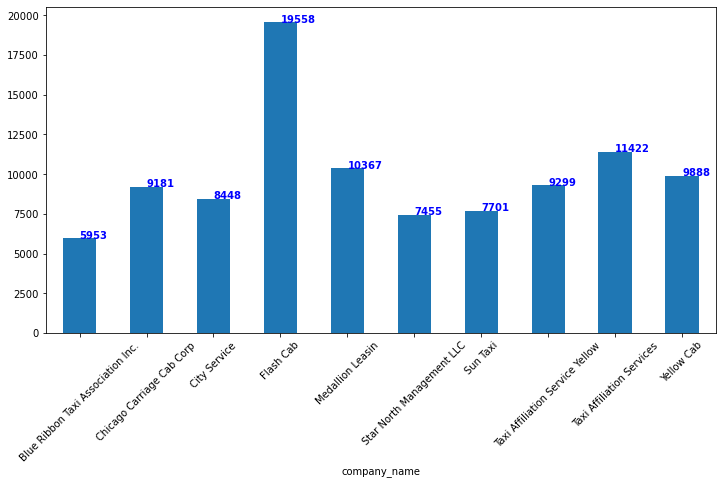

In [11]:
plot_bar(top_10_taxi_company,'company_name','trips_amount')

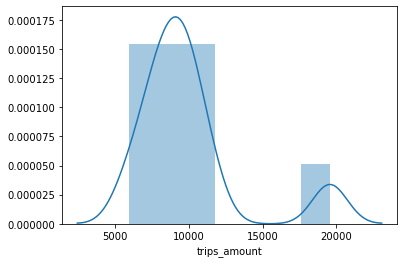

In [12]:
sns.distplot(top_10_taxi_company['trips_amount'])

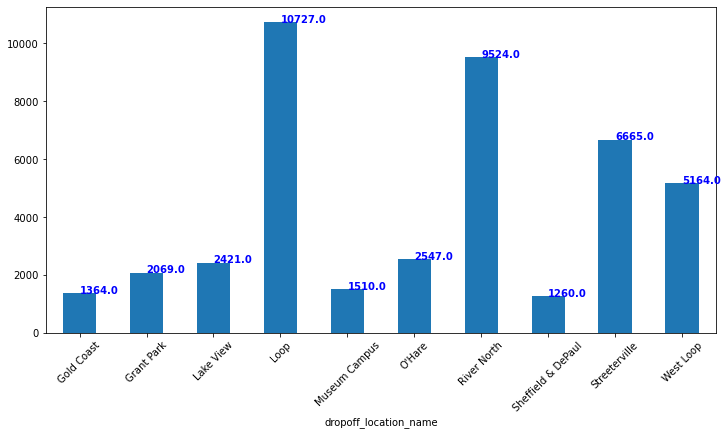

In [13]:
plot_bar(top_10,'dropoff_location_name','average_trips')

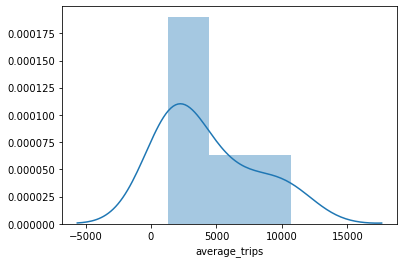

In [14]:
sns.distplot(top_10['average_trips'])

**Summary:**

From the graph about the trips_amount each taxi company achieved I can see that 'Flash Cab' has the most of the the rides while all other are close to each other. About average tips to each location I can see that We have two 'hot' location which are Loop and River North. Air port O'Hare has some low average trips probably people use taxis more often between neighborhoods. Upon checking the distance between Loop and River North is about one mile so I can guess that they are high together since people travel between the two.

# <font color ='green'> Task: Testing hypotheses  </font>

In [16]:
q7_results.head()

,start_ts,weather_conditions,duration_seconds
0,2017-11-25 16:00:00,Good,2410.0
1,2017-11-25 14:00:00,Good,1920.0
2,2017-11-25 12:00:00,Good,1543.0
3,2017-11-04 10:00:00,Good,2512.0
4,2017-11-11 07:00:00,Good,1440.0


In [17]:
q7_results.dtypes

start_ts               object
weather_conditions     object
duration_seconds      float64
dtype: object

In [18]:
q7_results['start_ts'] = pd.to_datetime(q7_results['start_ts'])

In [19]:
q7_results_good = q7_results.query('weather_conditions == "Good"')
q7_results_bad = q7_results.query('weather_conditions == "Bad"')

**Null hypothesis:** The average duration of rides from Loop neighborhood to O'Hare International Airport are equal on every sunday. (mu_good == mu_bad)<br>
**Alternative Hypothesis:** The average duration of rides from Loop neighborhood to O'Hare International Airport changes on rainy Sundays.(mu_good != mu_bad)

In [20]:
alpha = 0.05
q7_results_good['duration_seconds'].mean(), q7_results_bad['duration_seconds'].mean()

(1999.6756756756756, 2427.2055555555557)

I expect to reject the null hypothesis.

In [21]:
results = st.ttest_ind(
        q7_results_good['duration_seconds'], 
        q7_results_bad['duration_seconds'],equal_var=False)

if (results.pvalue < alpha):
    print("We reject the null hypothesis")
else:
    print("We can't reject the null hypothesis")

We reject the null hypothesis


**Summary:**

Since the null hypothesis is got rejected, I can conculde that with confidence level of 0.05 the average duration of ride from loop neighborhood to O'Hare airport are not equal on a rainy sunday and sunny sunday